# Load all required libraries

In [1]:
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:        11834300 kB
MemAvailable:   12396536 kB
Buffers:           43576 kB
Cached:           702968 kB
SwapCached:            0 kB
Active:           733088 kB
Inactive:         534136 kB
Active(anon):     500644 kB
Inactive(anon):      332 kB
Active(file):     232444 kB
Inactive(file):   533804 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               512 kB
Writeback:             0 kB
AnonPages:        520752 kB
Mapped:           183276 kB
Shmem:               952 kB
Slab:             114740 kB
SReclaimable:      74736 kB
SUnreclaim:        40004 kB
KernelStack:        4176 kB
PageTables:         6360 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2934144 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11307700783065993489, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17003983844505562565
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14292558763043896464
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10774229163921700750
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [0]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
import tensorflow as tf

In [0]:
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load our grayscale(L) and AB images from files

In [0]:
images_gray = np.load('/content/gdrive/My Drive/Colab Notebooks/image-colorization/l/gray_scale.npy')
images_lab = np.load('/content/gdrive/My Drive/Colab Notebooks/image-colorization/ab/ab/ab1.npy')

# Check counts of images in each dataset, for confirmation

In [10]:
len(images_gray)

25000

In [11]:
len(images_lab)

10000

# Verify, based on shape, that grayscale images(L) and AB images have expected layers in them

In [12]:
images_gray[0].shape

(224, 224)

In [13]:
images_lab[0].shape

(224, 224, 2)

# Make a function to grab the grayscale(L), A and B components of our overall LAB image

- This function also converts the aggregated (complete) LAB image into a RGB format prior to returning

In [0]:
def create_color_image_from_lab_grayscale(img_gray, img_lab):
    # import required packages
    import cv2
    import numpy as np
    
    # create a basic numpy array to contain our disaggregated image
    img = np.zeros((224, 224, 3))
    
    # add our grayscale part to layer one ('L')
    img[:, :, 0] = img_gray
    
    # add the two ('A' and 'B') layers from lab on top of the grayscale level one to get the "complete function"
    img[:, :, 1:] = img_lab
    img = img.astype('uint8')
    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img_

# Test out the grayscale image

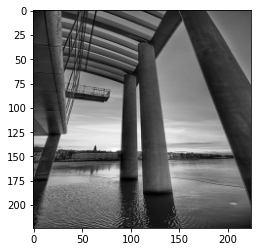

In [21]:
plt.imshow(images_gray[5], cmap="gray")

# Colorized (aggregated) image

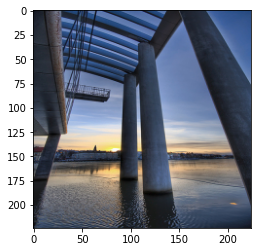

In [22]:
img_complete = create_color_image_from_lab_grayscale(images_gray[5],images_lab[5])
plt.imshow(img_complete)

# Define another function to generate a batch of images instead of just one image for our use

In [0]:
def get_rbg_from_lab(gray_imgs, ab_imgs, n = 10):
    
    imgs = np.zeros((n, 224, 224, 3))
    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]
    
    imgs = imgs.astype("uint8")
    
    imgs_ = []
    for i in range(0, n):
        imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

    imgs_ = np.array(imgs_)

    print(imgs_.shape)
    
    return imgs_

(6, 224, 224, 3)


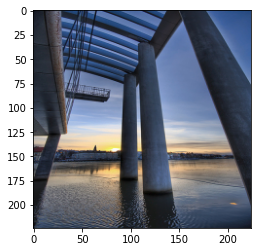

In [24]:
temp = get_rbg_from_lab(images_gray, images_lab, n=6)
plt.imshow(temp[5])

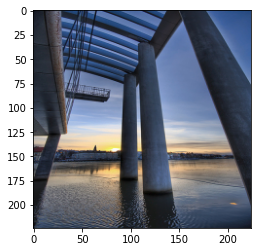

In [25]:
plt.imshow(create_color_image_from_lab_grayscale(images_gray[5],images_lab[5]))

# Try out a new model for experimentation, using the MobileNetV2

Reimport everything, plus anything again if necessary

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, LeakyReLU, BatchNormalization, Input, Concatenate, Activation, concatenate
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV2
import random
from PIL import Image
import os

In [0]:
    # prepare the kernel initializer values
    weight_init = RandomNormal(stddev=0.02)

    # prepare the Input layer
    net_input = Input((224,224,3))

    # download mobile net, and use it as the base.
    mobile_net_base = MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet'
    )
    mobilenet = mobile_net_base(net_input)

    # encoder block #
    # 224x224
    conv1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(net_input)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 112x112
    conv2 = Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(conv1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)

    # 112x112
    conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv2)
    conv3 =  Activation('relu')(conv3)

    # 56x56
    conv4 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv3)
    conv4 = Activation('relu')(conv4)

    # 28x28
    conv4_ = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(conv4)
    conv4_ = Activation('relu')(conv4_)

    # 28x28
    conv5 = Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv4_)
    conv5 = Activation('relu')(conv5)

    # 14x14
    conv5_ = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv5)
    conv5_ = Activation('relu')(conv5_)
    
    #7x7
    # fusion layer - connect MobileNet with our encoder
    conc = concatenate([mobilenet, conv5_])
    fusion = Conv2D(512, (1, 1), padding='same', kernel_initializer=weight_init)(conc)
    fusion = Activation('relu')(fusion)
    
    # skip fusion layer
    skip_fusion = concatenate([fusion, conv5_])
    
    # decoder block #
    # 7x7
    decoder = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_fusion)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # skip layer from conv5 (with added dropout)
    skip_4_drop = Dropout(0.25)(conv5)
    skip_4 = concatenate([decoder, skip_4_drop])
    
    # 14x14
    decoder = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_4)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # skip layer from conv4_ (with added dropout)
    skip_3_drop = Dropout(0.25)(conv4_)
    skip_3 = concatenate([decoder, skip_3_drop])
    
    # 28x28
    decoder = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_3)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # 56x56
    decoder = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # 112x112
    decoder = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)

    # 112x112
    decoder = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)
    
    # 224x224
    # output layer, with 2 channels (a and b)
    output_layer = Conv2D(2, (1, 1), activation='tanh')(decoder)

In [41]:
mobile_net_base.input

<tf.Tensor 'input_2:0' shape=(None, 224, 224, 3) dtype=float32>

In [42]:
modelv2.input

<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>

In [39]:
mobile_net_base.output

<tf.Tensor 'out_relu/Identity:0' shape=(None, 7, 7, 1280) dtype=float32>

In [40]:
modelv2.output

<tf.Tensor 'predictions/Identity:0' shape=(None, 1000) dtype=float32>

In [0]:
model = Model(net_input, output_layer)
model.compile(Adam(lr=0.0002), loss='mse', metrics=['accuracy'])

In [0]:
def train(model, gray, ab, epochs, batch_size):
    # setup the training input data (grayscale images)
    train_in = gray

    # convert the shape from (224, 224, 1) to (224, 224, 3) by copying the value to match MobileNet's requirements
    train_in = np.repeat(train_in[..., np.newaxis], 3, -1)
    
    train_out = ab
    # normalize the data
    train_in = (train_in.astype('float32') - 127.5) / 127.5
    train_out = (train_out.astype('float32') - 127.5) / 127.5

    history = model.fit(
        train_in,
        train_out,
        epochs=epochs,
        validation_split=0.05,
        batch_size=batch_size
    )
    
    return history

In [18]:
BATCH_SIZE = 32
EPOCHS = 30
history = train(model, images_gray[:3000], images_lab[:3000], EPOCHS, BATCH_SIZE)

Epoch 1/30
90/90 [==============================] - 98s 1s/step - loss: 0.0171 - accuracy: 0.5135 - val_loss: 0.0176 - val_accuracy: 0.5261
Epoch 2/30
90/90 [==============================] - 93s 1s/step - loss: 0.0159 - accuracy: 0.5157 - val_loss: 0.0174 - val_accuracy: 0.5723
Epoch 3/30
90/90 [==============================] - 93s 1s/step - loss: 0.0144 - accuracy: 0.6133 - val_loss: 0.0174 - val_accuracy: 0.5821
Epoch 4/30
90/90 [==============================] - 92s 1s/step - loss: 0.0131 - accuracy: 0.6343 - val_loss: 0.0188 - val_accuracy: 0.5804
Epoch 5/30
90/90 [==============================] - 93s 1s/step - loss: 0.0123 - accuracy: 0.6599 - val_loss: 0.0174 - val_accuracy: 0.5931
Epoch 6/30
90/90 [==============================] - 92s 1s/step - loss: 0.0119 - accuracy: 0.6715 - val_loss: 0.0179 - val_accuracy: 0.5866
Epoch 7/30
90/90 [==============================] - 92s 1s/step - loss: 0.0114 - accuracy: 0.6798 - val_loss: 0.0180 - val_accuracy: 0.5755
Epoch 8/30
90/90 [==

In [0]:
def get_pred(model, image_l):
    # repeat the L value to match input shape
    image_l_R = np.repeat(image_l[..., np.newaxis], 3, -1)
    image_l_R = image_l_R.reshape((1, 224, 224, 3))

    # normalize the input
    image_l_R = (image_l_R.astype('float32') - 127.5) / 127.5

    # make prediction
    prediction = model.predict(image_l_R)

    # normalize the output
    pred = (prediction[0].astype('float32') * 127.5) + 127.5
    return pred

In [0]:
def get_LAB(image_l, image_ab):
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb

In [0]:
def create_sample(model, images_gray, amount):
    path = "/content/gdrive/My Drive/Colab Notebooks/image-colorization/folder_to_save_graph_3/"
    samples = []
    for i in range(amount):
        # select random images
        r = random.randint(0, images_gray.shape[0])

        # get the model's prediction
        pred = get_pred(model, images_gray[r])

        # combine input and output to LAB image
        image = get_LAB(images_gray[r], pred)

        # get number of images in output folder
        count = len(os.listdir(path))

        # create new combined image, save it
        new_image = Image.new('RGB', (448, 224))
        gray_image = Image.fromarray(images_gray[r])
        new_image.paste(gray_image, (0,0))
        new_image.paste(image, (224, 0))

        new_image.save(path + str(count)+('_%i.png' % r))
        samples.append(new_image)
    return samples

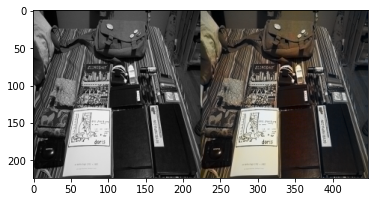

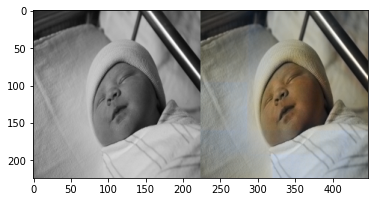

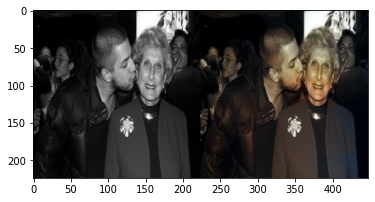

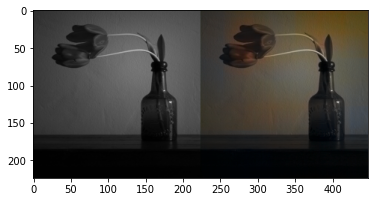

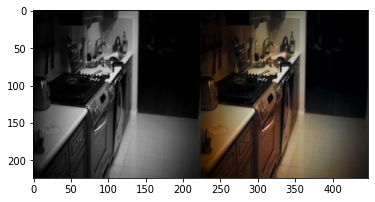

In [28]:
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

Now this looks pretty encouraging! Next steps should be to train this further for more epochs + using more data.